# A how-to for creating portfolios and simulating strategies.

In [1]:
from simulator import HistoricalSimulator
from strategies import SMAStrategy, VolTargetStrategy
from portfolio_maker import PortfolioMaker

In [2]:
from datetime import datetime, timedelta
from types import MethodType
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import requests
import time

## *experimenting with `PortfolioMaker`*

In [3]:
pf = PortfolioMaker(0, relative_core_frac=True)

In [4]:
# add core assets
pf.add_ticker('NFLX', .4)
pf.add_ticker('AAPL', .15)
pf.add_ticker('MSFT', .15)
pf.add_ticker('DIS', .1)

pf.assets

{'NFLX': {'label': 'core', 'fraction': 0.4},
 'AAPL': {'label': 'core', 'fraction': 0.15},
 'MSFT': {'label': 'core', 'fraction': 0.15},
 'DIS': {'label': 'core', 'fraction': 0.1}}

In [5]:
# add satellite assets
pf.add_ticker('AMZN', label='satellite', in_market=True)
pf.add_ticker('VBMFX', label='satellite', in_market=True)

pf.assets

{'NFLX': {'label': 'core', 'fraction': 0.4},
 'AAPL': {'label': 'core', 'fraction': 0.15},
 'MSFT': {'label': 'core', 'fraction': 0.15},
 'DIS': {'label': 'core', 'fraction': 0.1},
 'AMZN': {'label': 'satellite', 'in_mkt': True},
 'VBMFX': {'label': 'satellite', 'in_mkt': True}}

In [6]:
# editing sat_frac will change core asset fractions when relative_core_frac==True
pf.sat_frac = .2

pf.assets

core fractions adjusted relative to new `sat_frac` value


{'NFLX': {'label': 'core', 'fraction': 0.32},
 'AAPL': {'label': 'core', 'fraction': 0.12},
 'MSFT': {'label': 'core', 'fraction': 0.12},
 'DIS': {'label': 'core', 'fraction': 0.08},
 'AMZN': {'label': 'satellite', 'in_mkt': True},
 'VBMFX': {'label': 'satellite', 'in_mkt': True}}

In [7]:
# if you want to change an existing core asset...
pf.edit_ticker_fraction('NFLX', .5)

# if you want to change an existing satellite asset...
pf.edit_ticker_mkt_status('VBMFX', False)

pf.assets

{'NFLX': {'label': 'core', 'fraction': 0.4},
 'AAPL': {'label': 'core', 'fraction': 0.12},
 'MSFT': {'label': 'core', 'fraction': 0.12},
 'DIS': {'label': 'core', 'fraction': 0.08},
 'AMZN': {'label': 'satellite', 'in_mkt': True},
 'VBMFX': {'label': 'satellite', 'in_mkt': False}}

In [8]:
# switch whether changing sat_frac adjusts core asset fractions
pf.relative_core_frac = False

pf.assets

core fractions reset to their originally entered values


{'NFLX': {'label': 'core', 'fraction': 0.5},
 'AAPL': {'label': 'core', 'fraction': 0.15},
 'MSFT': {'label': 'core', 'fraction': 0.15},
 'DIS': {'label': 'core', 'fraction': 0.1},
 'AMZN': {'label': 'satellite', 'in_mkt': True},
 'VBMFX': {'label': 'satellite', 'in_mkt': False}}

In [9]:
# if no error is thrown from this method
# this PortfolioMaker instance is ready for use in a simulation
# (error thrown here on purpose)
pf.check_assets()

core assets and target holding fraction(s):
50.00000% in NFLX
15.00000% in AAPL
15.00000% in MSFT
10.00000% in DIS
*** 90.00000% in core overall ***
----------------
satellite assets and target holding fraction(s):
in-market asset:     AMZN
out-of-market asset: VBMFX
*** 20.00000% in satellite overall ***
----------------


ValueError: Make sure core and satellite fractions add up to 1 (100%) before moving on to simulations.

In [10]:
# you can adjust fractions as shown above,
# but here i'll just remove an asset
pf.remove_ticker('DIS')

In [11]:
pf.check_assets()

core assets and target holding fraction(s):
50.00000% in NFLX
15.00000% in AAPL
15.00000% in MSFT
*** 80.00000% in core overall ***
----------------
satellite assets and target holding fraction(s):
in-market asset:     AMZN
out-of-market asset: VBMFX
*** 20.00000% in satellite overall ***
----------------
-----passed-----
----------------
benchmark assets and target holding fraction(s):
None.
----------------
-----passed-----



## *simulating a strategy*

I'll demonstrate a simulation with `SMAStrategy` (SMA for simple moving average). It places 100% of the portfolio's satellite portion in either the in-market or out-of-market asset.

It chooses between them by tracking some asset's price on rebalance days and comparing that to its 200 day simple moving average. It's a little more complicated than this, but roughly, if the tracked asset's price is 101% or more of its SMA, it buys into the in-market asset. Otherwise, it retreats into the out-of-market asset.

**As such, the `SMAStrategy` class has a special requirement that one of the tickers in `assets` has a key named `'track'` whose value is `True`.**

In [12]:
# i'll set SPY as the tracked asset and put it together with AGG
# to create a benchmark portfolio whose result you can compare to
# the core-satellite when the simulation is done
pf.add_ticker('SPY', .6, label='benchmark', track=True)
pf.add_ticker('AGG', .4, label='benchmark')

In [13]:
# check code for SMAStrategy() and HistoricalSimulator()
# to learn more about arguments; i'll write full descriptions soon
smas = SMAStrategy(pf, burn_in=200,
                   start_date=datetime(2013, 1, 1),
                   end_date=datetime(2015, 1, 1),
                   sat_rb_freq=365.25, tot_rb_freq=1, cash=1e4)

core assets and target holding fraction(s):
50.00000% in NFLX
15.00000% in AAPL
15.00000% in MSFT
*** 80.00000% in core overall ***
----------------
satellite assets and target holding fraction(s):
in-market asset:     AMZN
out-of-market asset: VBMFX
*** 20.00000% in satellite overall ***
----------------
-----passed-----
----------------
benchmark assets and target holding fraction(s):
60.00000% in SPY
40.00000% in AGG
*** 100.00000% in benchmark overall ***
----------------
-----passed-----

NFLX from 2012-03-13 to 2015-01-01...
AAPL from 2012-03-13 to 2015-01-01...
MSFT from 2012-03-13 to 2015-01-01...
AMZN from 2012-03-13 to 2015-01-01...
VBMFX from 2012-03-13 to 2015-01-01...
SPY from 2012-03-13 to 2015-01-01...
AGG from 2012-03-13 to 2015-01-01...
sat [ 1  2  3  4  5  6  7  8  9 10 11 12] 
tot [12]
[12] 2012
[ 1  2  3  4  5  6  7  8  9 10 11 12] 2013
[ 1  2  3  4  5  6  7  8  9 10 11 12] 2014
[] 2015
0.002 s for rebalance info loop


In [14]:
# assets is the main object -- it's basically PorfolioMaker's assets
# dict, but each ticker's dict adds new keys that contain a DataFrame
# with price data ('df') and how many shares of the asset you currently
# own ('shares')
for key, val in smas.assets.items():
    print(f"{key} asset dict's keys: {[k for k in val.keys()]}")

NFLX asset dict's keys: ['label', 'fraction', 'df', 'shares']
AAPL asset dict's keys: ['label', 'fraction', 'df', 'shares']
MSFT asset dict's keys: ['label', 'fraction', 'df', 'shares']
AMZN asset dict's keys: ['label', 'in_mkt', 'df', 'shares']
VBMFX asset dict's keys: ['label', 'in_mkt', 'df', 'shares']
SPY asset dict's keys: ['label', 'fraction', 'track', 'df', 'shares']
AGG asset dict's keys: ['label', 'fraction', 'df', 'shares']


In [15]:
# recall that the first approximately `burn_in` indices (~200 in this example)
# come before the specified start date so there's enough data to calculate the
# `burn_in`-day simple moving average when the real start date arrives
smas.assets['NFLX']['df'][smas.burn_in:].head()

,adjClose,adjHigh,adjLow,adjOpen,adjVolume,close,date,divCash,high,low,open,splitFactor,volume
200,12.761416,12.935701,12.699987,12.828559,11123011,89.33,2012-12-28 00:00:00+00:00,0.0,90.55,88.9000,89.80,1.0,1589000
201,13.227130,13.357129,12.715702,12.768559,18078918,92.59,2012-12-31 00:00:00+00:00,0.0,93.50,89.0100,89.38,1.0,2582700
202,13.144273,13.687129,12.955701,13.601415,19431319,92.01,2013-01-02 00:00:00+00:00,0.0,95.81,90.6900,95.21,1.0,2775900
203,13.798558,13.988557,13.075715,13.138558,27912527,96.59,2013-01-03 00:00:00+00:00,0.0,97.92,91.5301,91.97,1.0,3987500
204,13.711415,13.958557,13.648558,13.791415,17761117,95.98,2013-01-04 00:00:00+00:00,0.0,97.71,95.5400,96.54,1.0,2537300


In [16]:
# start the simulation. this prints out what happens on
# every rebalance date in your date range (total and satellite)
# (could probably use a 'verbose' flag)
smas.begin_time_loop()

**** on 2012-12-28 
vol streak:  1 can enter: True days out: 1
it's a total; sat_only is False; $10000.00 in account
it's a satellite; sat_only is False; $10000.00 in account
4: already in, balance in
deltas: [389.  23.  66.   8.   0.]
bought 389 shares of NFLX @$12.83 | $5009.69 in account
bought 23 shares of AAPL @$63.84 | $3541.33 in account
bought 66 shares of MSFT @$22.60 | $2049.73 in account
bought 8 shares of AMZN @$245.85 | $82.93 in account
**** on 2012-12-31 
vol streak:  2 can enter: True days out: 2
it's a satellite; sat_only is True; $82.93 in account
3: already in, remain in
**** on 2013-01-02 
vol streak:  3 can enter: True days out: 3
it's a satellite; sat_only is True; $82.93 in account
3: already in, remain in
**** on 2013-01-03 
vol streak:  4 can enter: True days out: 4
it's a satellite; sat_only is True; $82.93 in account
3: already in, remain in
**** on 2013-01-04 
vol streak:  5 can enter: True days out: 5
it's a satellite; sat_only is True; $82.93 in account
3:

**** on 2013-04-02 
vol streak:  64 can enter: True days out: 60
it's a satellite; sat_only is True; $82.93 in account
3: already in, remain in
**** on 2013-04-03 
vol streak:  65 can enter: True days out: 60
it's a satellite; sat_only is True; $82.93 in account
3: already in, remain in
**** on 2013-04-04 
vol streak:  66 can enter: True days out: 60
it's a satellite; sat_only is True; $82.93 in account
3: already in, remain in
**** on 2013-04-05 
vol streak:  67 can enter: True days out: 60
it's a satellite; sat_only is True; $82.93 in account
3: already in, remain in
**** on 2013-04-08 
vol streak:  68 can enter: True days out: 60
it's a satellite; sat_only is True; $82.93 in account
3: already in, remain in
**** on 2013-04-09 
vol streak:  69 can enter: True days out: 60
it's a satellite; sat_only is True; $82.93 in account
3: already in, remain in
**** on 2013-04-10 
vol streak:  70 can enter: True days out: 60
it's a satellite; sat_only is True; $82.93 in account
3: already in, re

**** on 2013-07-26 
vol streak:  145 can enter: True days out: 60
it's a satellite; sat_only is True; $82.93 in account
3: already in, remain in
**** on 2013-07-29 
vol streak:  146 can enter: True days out: 60
it's a satellite; sat_only is True; $82.93 in account
3: already in, remain in
**** on 2013-07-30 
vol streak:  147 can enter: True days out: 60
it's a satellite; sat_only is True; $82.93 in account
3: already in, remain in
**** on 2013-07-31 
vol streak:  148 can enter: True days out: 60
it's a satellite; sat_only is True; $82.93 in account
3: already in, remain in
**** on 2013-08-01 
vol streak:  149 can enter: True days out: 60
it's a satellite; sat_only is True; $82.93 in account
3: already in, remain in
**** on 2013-08-02 
vol streak:  150 can enter: True days out: 60
it's a satellite; sat_only is True; $82.93 in account
3: already in, remain in
**** on 2013-08-05 
vol streak:  151 can enter: True days out: 60
it's a satellite; sat_only is True; $82.93 in account
3: already

vol streak:  242 can enter: True days out: 60
it's a satellite; sat_only is True; $82.93 in account
3: already in, remain in
**** on 2013-12-13 
vol streak:  243 can enter: True days out: 60
it's a satellite; sat_only is True; $82.93 in account
3: already in, remain in
**** on 2013-12-16 
vol streak:  244 can enter: True days out: 60
it's a satellite; sat_only is True; $82.93 in account
3: already in, remain in
**** on 2013-12-17 
vol streak:  245 can enter: True days out: 60
it's a satellite; sat_only is True; $82.93 in account
3: already in, remain in
**** on 2013-12-18 
vol streak:  246 can enter: True days out: 60
it's a satellite; sat_only is True; $82.93 in account
3: already in, remain in
**** on 2013-12-19 
vol streak:  247 can enter: True days out: 60
it's a satellite; sat_only is True; $82.93 in account
3: already in, remain in
**** on 2013-12-20 
vol streak:  248 can enter: True days out: 60
it's a satellite; sat_only is True; $82.93 in account
3: already in, remain in
**** 

**** on 2014-03-20 
vol streak:  308 can enter: True days out: 60
it's a satellite; sat_only is True; $398.44 in account
3: already in, remain in
**** on 2014-03-21 
vol streak:  309 can enter: True days out: 60
it's a satellite; sat_only is True; $398.44 in account
3: already in, remain in
**** on 2014-03-24 
vol streak:  310 can enter: True days out: 60
it's a satellite; sat_only is True; $398.44 in account
3: already in, remain in
**** on 2014-03-25 
vol streak:  311 can enter: True days out: 60
it's a satellite; sat_only is True; $398.44 in account
3: already in, remain in
**** on 2014-03-26 
vol streak:  312 can enter: True days out: 60
it's a satellite; sat_only is True; $398.44 in account
3: already in, remain in
**** on 2014-03-27 
vol streak:  313 can enter: True days out: 60
it's a satellite; sat_only is True; $398.44 in account
3: already in, remain in
**** on 2014-03-28 
vol streak:  314 can enter: True days out: 60
it's a satellite; sat_only is True; $398.44 in account
3: 

**** on 2014-06-16 
vol streak:  368 can enter: True days out: 60
it's a satellite; sat_only is True; $398.44 in account
3: already in, remain in
**** on 2014-06-17 
vol streak:  369 can enter: True days out: 60
it's a satellite; sat_only is True; $398.44 in account
3: already in, remain in
**** on 2014-06-18 
vol streak:  370 can enter: True days out: 60
it's a satellite; sat_only is True; $398.44 in account
3: already in, remain in
**** on 2014-06-19 
vol streak:  371 can enter: True days out: 60
it's a satellite; sat_only is True; $398.44 in account
3: already in, remain in
**** on 2014-06-20 
vol streak:  372 can enter: True days out: 60
it's a satellite; sat_only is True; $398.44 in account
3: already in, remain in
**** on 2014-06-23 
vol streak:  373 can enter: True days out: 60
it's a satellite; sat_only is True; $398.44 in account
3: already in, remain in
**** on 2014-06-24 
vol streak:  374 can enter: True days out: 60
it's a satellite; sat_only is True; $398.44 in account
3: 

**** on 2014-10-28 
vol streak:  6 can enter: False days out: 12
it's a satellite; sat_only is True; $6.92 in account
7: already out, remain out
**** on 2014-10-29 
vol streak:  7 can enter: False days out: 13
it's a satellite; sat_only is True; $6.92 in account
7: already out, remain out
**** on 2014-10-30 
vol streak:  8 can enter: False days out: 14
it's a satellite; sat_only is True; $6.92 in account
7: already out, remain out
**** on 2014-10-31 
vol streak:  9 can enter: False days out: 15
it's a satellite; sat_only is True; $6.92 in account
7: already out, remain out
**** on 2014-11-03 
vol streak:  10 can enter: False days out: 16
it's a satellite; sat_only is True; $6.92 in account
7: already out, remain out
**** on 2014-11-04 
vol streak:  11 can enter: False days out: 17
it's a satellite; sat_only is True; $6.92 in account
7: already out, remain out
**** on 2014-11-05 
vol streak:  12 can enter: False days out: 18
it's a satellite; sat_only is True; $6.92 in account
7: alread

end date strategy holdings: [('NFLX', 292.0), ('AAPL', 41.0), ('MSFT', 100.0), ('AMZN', 0), ('VBMFX', 600.0), ('SPY', 0), ('AGG', 0)]
end date strategy portfolio value: $28,374.03


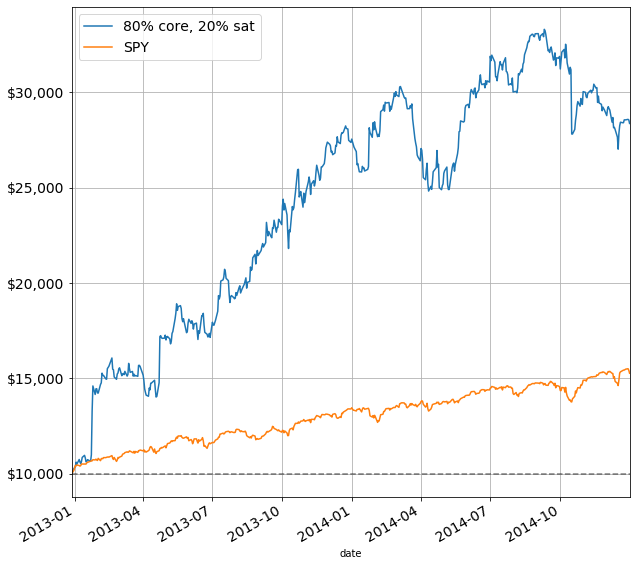

In [17]:
# plot the results. it's on my list to write a method
# in HistoricalSimulator that can automate this process
# and display results for the benchmark portfolio, too

ax = smas.strategy_results.plot(x='date', y='value',
                              label=(f"{smas.core_frac*1e2:.0f}% core, "
                                     f"{smas.sat_frac*1e2:.0f}% sat"),
                              figsize=(10,10), fontsize=14)#, logy=True)

# plot a placeholder that will eventually be the benchmark portfolio's results
nudf = smas.assets['SPY']['df'][smas.burn_in:].copy()
factr = 10000 / nudf['adjClose'][smas.burn_in]
nudf['adjClose'] *= factr
nudf.plot(x='date', y='adjClose', label='SPY', ax=ax)#, logy=True)

ax.legend(fontsize=14)
plt.axhline(1e4, linestyle='--', c='k', alpha=.5)
ax.grid()

ax.get_yaxis().set_major_formatter(
    mpl.ticker.FuncFormatter(lambda x, _: f"${x:,.0f}"))
# adapted from https://stackoverflow.com/a/25973637
# and https://stackoverflow.com/a/10742904

print('end date strategy holdings: '
      f"{[(nm, smas.assets[nm]['shares']) for nm in smas.assets.keys()]}")
print('end date strategy portfolio value: '
      f"${smas.portfolio_value(False, len(smas.all_dates) - 1):,.02f}")

Naturally, this portfolio would have gone to the moon.

**The idea from here is to try out different instances of `SMAStrategy` (or whichever strategy class) and vary assets, core/satellite allocations, dates, rebalance frequencies, etc. to see what would have led to the best historical results.**